In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(" All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

 All libraries imported successfully!
Pandas version: 2.2.3
NumPy version: 2.1.3


In [2]:
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
movies = pd.read_csv('../data/ml-latest-small/movies.csv')

print("="*60)
print(" DATASET OVERVIEW")
print("="*60)
print(f"\n Ratings dataset shape: {ratings.shape}")
print(f" Movies dataset shape: {movies.shape}")

print("\n" + "="*60)
print(" First 5 Ratings:")
print("="*60)
print(ratings.head())

print("\n" + "="*60)
print(" First 5 Movies:")
print("="*60)
print(movies.head())

print("\n" + "="*60)
print(" Ratings Statistics:")
print("="*60)
print(ratings.describe())

 DATASET OVERVIEW

 Ratings dataset shape: (100836, 4)
 Movies dataset shape: (9742, 3)

 First 5 Ratings:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

 First 5 Movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

 Ratings Statistics:
              userId        mo

🔍 DATA QUALITY CHECK - MISSING VALUES

 Ratings Dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Total missing values: 0

 Movies Dataset:
movieId    0
title      0
genres     0
dtype: int64
Total missing values: 0


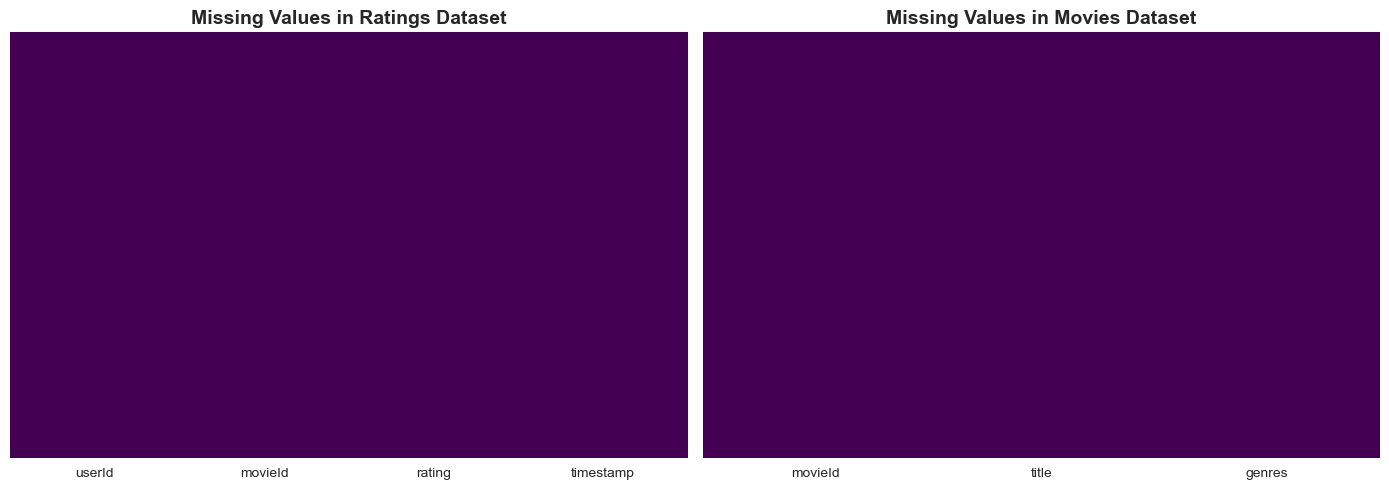


 Data Quality Check Complete!


In [3]:
print("="*60)
print("🔍 DATA QUALITY CHECK - MISSING VALUES")
print("="*60)

# Check missing values in ratings
print("\n Ratings Dataset:")
print(ratings.isnull().sum())
print(f"Total missing values: {ratings.isnull().sum().sum()}")

# Check missing values in movies
print("\n Movies Dataset:")
print(movies.isnull().sum())
print(f"Total missing values: {movies.isnull().sum().sum()}")

# Visualize missing data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ratings missing data heatmap
sns.heatmap(ratings.isnull(), cbar=False, yticklabels=False, ax=axes[0], cmap='viridis')
axes[0].set_title('Missing Values in Ratings Dataset', fontsize=14, fontweight='bold')

# Movies missing data heatmap
sns.heatmap(movies.isnull(), cbar=False, yticklabels=False, ax=axes[1], cmap='viridis')
axes[1].set_title('Missing Values in Movies Dataset', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Data Quality Check Complete!")

 RATING DISTRIBUTION ANALYSIS

 Merged dataset shape: (100836, 6)
 Columns: ['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres']

 Rating Value Counts:
rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64


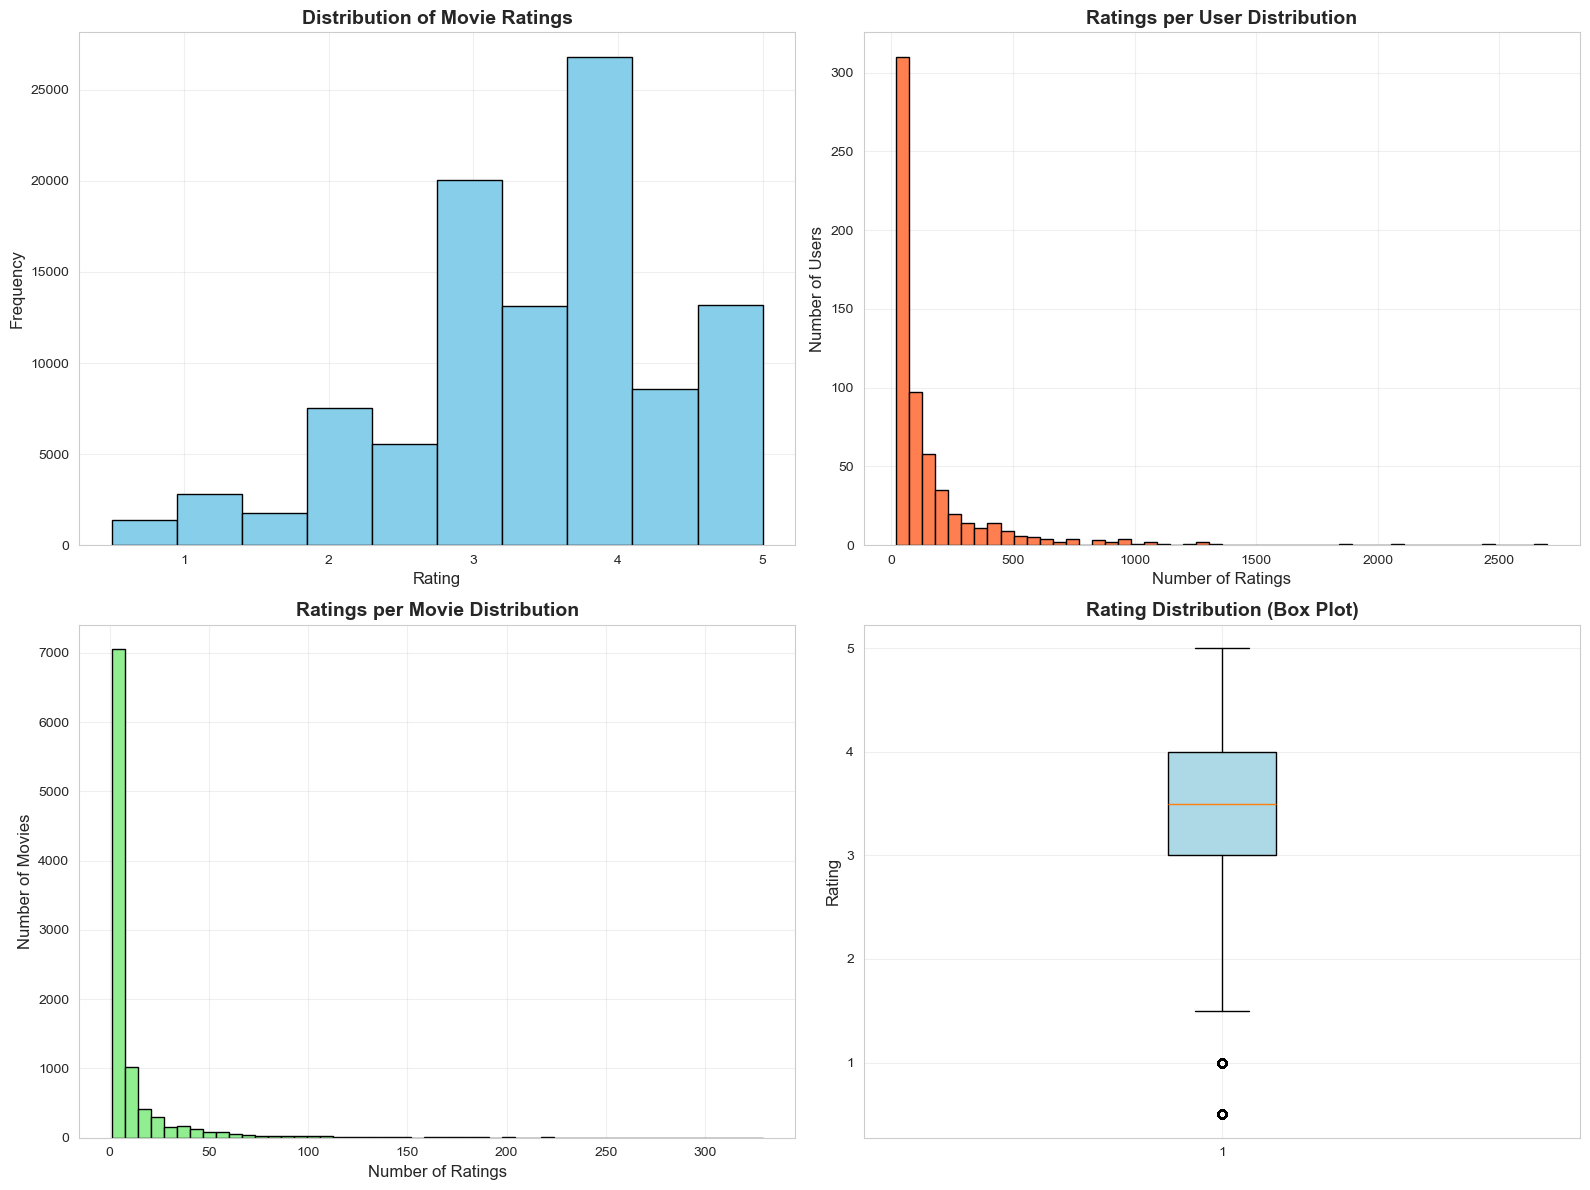


 Distribution Analysis Complete!


In [4]:
print("="*60)
print(" RATING DISTRIBUTION ANALYSIS")
print("="*60)

# Merge ratings with movies to get more context
df = ratings.merge(movies, on='movieId', how='left')

print(f"\n Merged dataset shape: {df.shape}")
print(f" Columns: {list(df.columns)}")

# Rating distribution
print("\n Rating Value Counts:")
print(df['rating'].value_counts().sort_index())

# Visualize rating distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Rating Distribution
axes[0, 0].hist(df['rating'], bins=10, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Rating', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Movie Ratings', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Ratings per User
ratings_per_user = df.groupby('userId').size()
axes[0, 1].hist(ratings_per_user, bins=50, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Number of Ratings', fontsize=12)
axes[0, 1].set_ylabel('Number of Users', fontsize=12)
axes[0, 1].set_title('Ratings per User Distribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Ratings per Movie
ratings_per_movie = df.groupby('movieId').size()
axes[1, 0].hist(ratings_per_movie, bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('Number of Ratings', fontsize=12)
axes[1, 0].set_ylabel('Number of Movies', fontsize=12)
axes[1, 0].set_title('Ratings per Movie Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot of ratings
axes[1, 1].boxplot(df['rating'], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue'))
axes[1, 1].set_ylabel('Rating', fontsize=12)
axes[1, 1].set_title('Rating Distribution (Box Plot)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Distribution Analysis Complete!")

 ANOMALY DETECTION - Finding Suspicious Ratings

 User Statistics Sample:
   userId  num_ratings  avg_rating  std_rating  unique_movies
0       1          232    4.366379    0.800048            232
1       2           29    3.948276    0.805615             29
2       3           39    2.435897    2.090642             39
3       4          216    3.555556    1.314204            216
4       5           44    3.636364    0.990441             44
5       6          314    3.493631    0.850648            314
6       7          152    3.230263    1.329594            152
7       8           47    3.574468    0.972328             47
8       9           46    3.260870    1.272526             46
9      10          140    3.278571    1.175700            140

 Anomaly Detection Results:
 Normal users: 579
 Anomalous users: 31
 Anomaly percentage: 5.08%

 Sample Anomalous Users:
     userId  num_ratings  avg_rating  std_rating  unique_movies  anomaly
2         3           39    2.435897    2.090642 

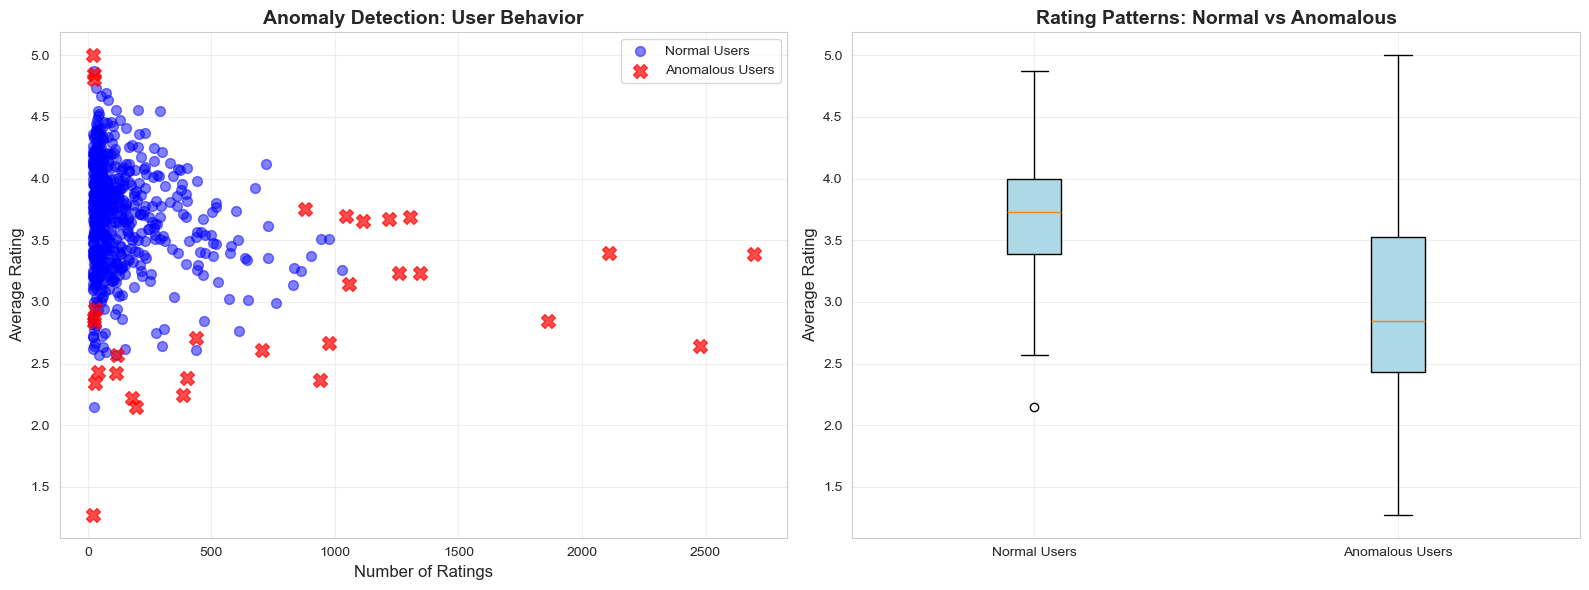


 Anomaly Detection Complete!


In [5]:
print("="*60)
print(" ANOMALY DETECTION - Finding Suspicious Ratings")
print("="*60)

# Create features for anomaly detection
user_stats = df.groupby('userId').agg({
    'rating': ['count', 'mean', 'std'],
    'movieId': 'nunique'
}).reset_index()

user_stats.columns = ['userId', 'num_ratings', 'avg_rating', 'std_rating', 'unique_movies']

# Fill NaN std (users with only 1 rating)
user_stats['std_rating'] = user_stats['std_rating'].fillna(0)

print("\n User Statistics Sample:")
print(user_stats.head(10))

# Use Isolation Forest to detect anomalous users
features = user_stats[['num_ratings', 'avg_rating', 'std_rating']].values

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Detect anomalies
iso_forest = IsolationForest(contamination=0.05, random_state=42)
user_stats['anomaly'] = iso_forest.fit_predict(features_scaled)

# -1 means anomaly, 1 means normal
anomalous_users = user_stats[user_stats['anomaly'] == -1]
normal_users = user_stats[user_stats['anomaly'] == 1]

print(f"\n Anomaly Detection Results:")
print(f" Normal users: {len(normal_users)}")
print(f" Anomalous users: {len(anomalous_users)}")
print(f" Anomaly percentage: {len(anomalous_users)/len(user_stats)*100:.2f}%")

print("\n Sample Anomalous Users:")
print(anomalous_users.head(10))

# Visualize anomalies
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot: Number of ratings vs Average rating
axes[0].scatter(normal_users['num_ratings'], normal_users['avg_rating'], 
                c='blue', alpha=0.5, label='Normal Users', s=50)
axes[0].scatter(anomalous_users['num_ratings'], anomalous_users['avg_rating'], 
                c='red', alpha=0.7, label='Anomalous Users', s=100, marker='X')
axes[0].set_xlabel('Number of Ratings', fontsize=12)
axes[0].set_ylabel('Average Rating', fontsize=12)
axes[0].set_title('Anomaly Detection: User Behavior', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot comparison
data_to_plot = [normal_users['avg_rating'], anomalous_users['avg_rating']]
axes[1].boxplot(data_to_plot, labels=['Normal Users', 'Anomalous Users'],
                patch_artist=True,
                boxprops=dict(facecolor='lightblue'))
axes[1].set_ylabel('Average Rating', fontsize=12)
axes[1].set_title('Rating Patterns: Normal vs Anomalous', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Anomaly Detection Complete!")

 DATA DRIFT DETECTION

 Training data size: 80668
 Production data size: 20168

 Training Data - Rating Distribution:
rating
0.5    0.011851
1.0    0.029690
1.5    0.014578
2.0    0.077168
2.5    0.047268
3.0    0.208075
3.5    0.124758
4.0    0.276181
4.5    0.078532
5.0    0.131899
Name: proportion, dtype: float64

 Production Data - Rating Distribution:
rating
0.5    0.020528
1.0    0.020627
1.5    0.030494
2.0    0.065748
2.5    0.086127
3.0    0.161741
3.5    0.152321
4.0    0.225060
4.5    0.109877
5.0    0.127479
Name: proportion, dtype: float64

 Statistical Comparison:
Training Mean: 3.508 | Production Mean: 3.474
Training Std: 1.033 | Production Std: 1.078
Mean Difference: 0.035

 No significant drift detected in rating mean


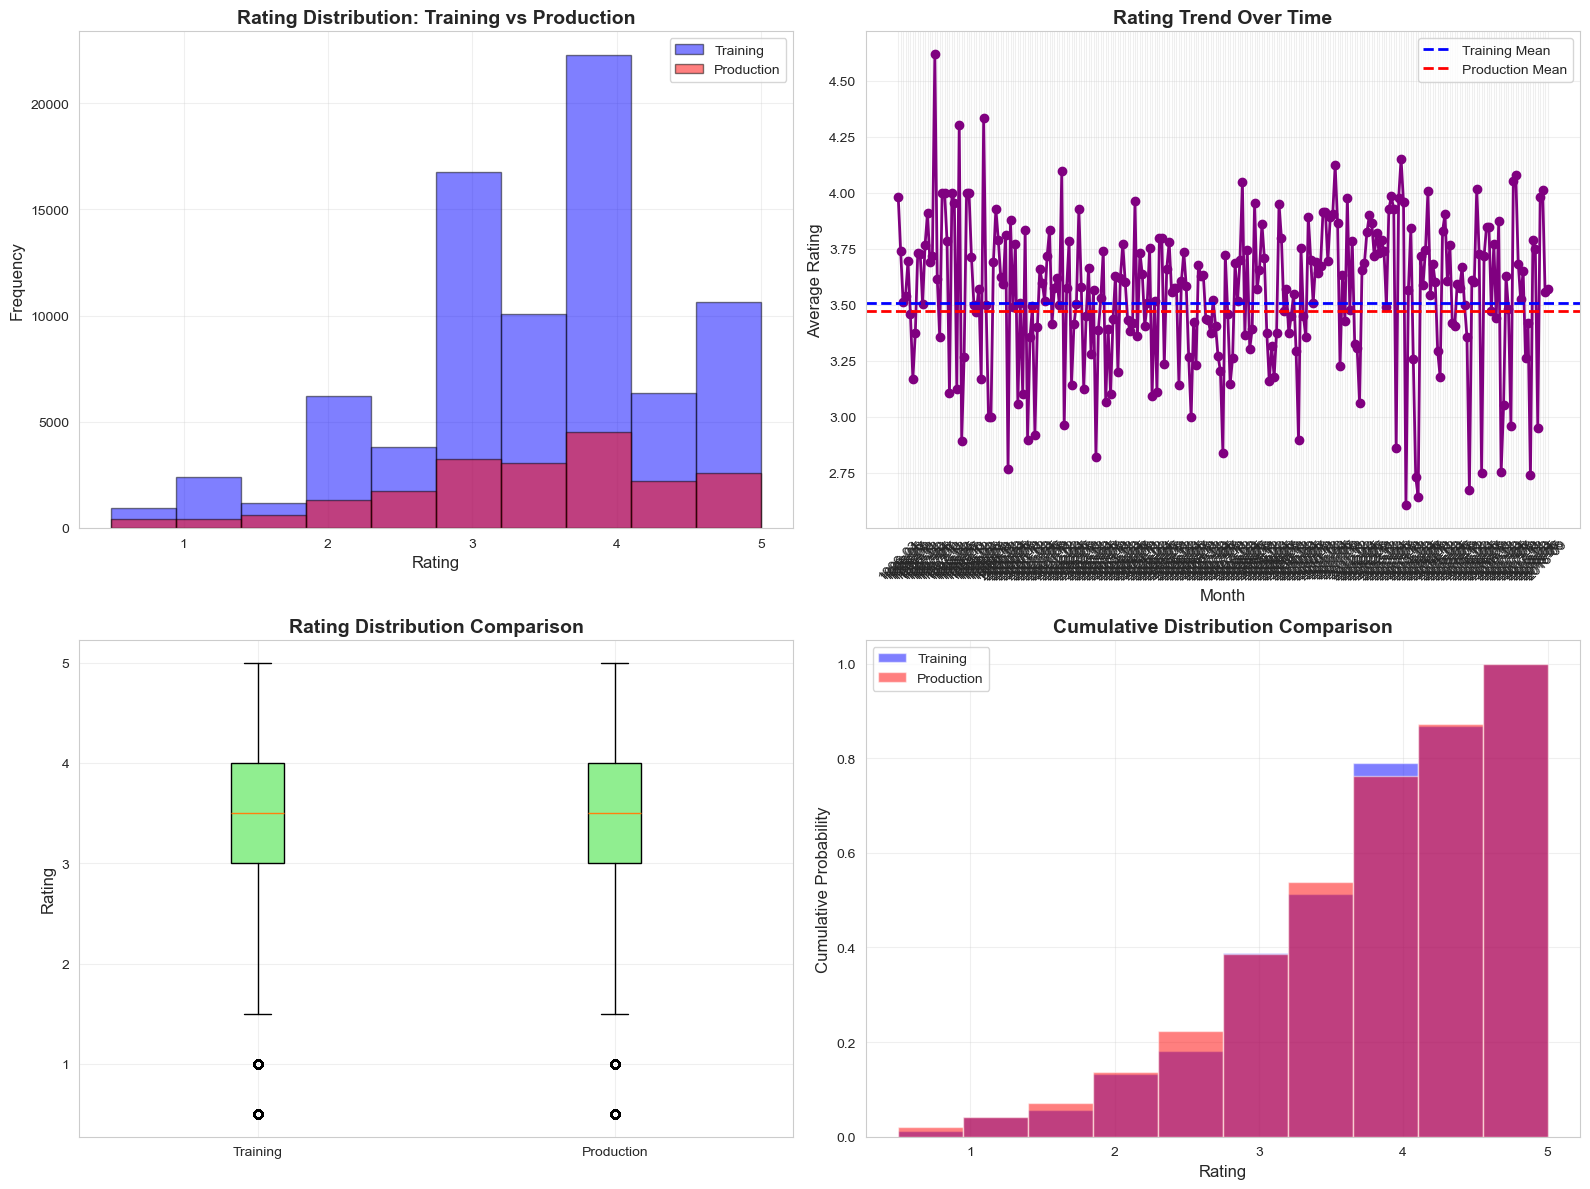


 Data Drift Analysis Complete!


In [6]:
print("="*60)
print(" DATA DRIFT DETECTION")
print("="*60)

# Split data into "training" (older) and "production" (newer) based on timestamp
df_sorted = df.sort_values('timestamp')
split_point = int(len(df_sorted) * 0.8)

training_data = df_sorted.iloc[:split_point]
production_data = df_sorted.iloc[split_point:]

print(f"\n Training data size: {len(training_data)}")
print(f" Production data size: {len(production_data)}")

# Compare distributions
print("\n Training Data - Rating Distribution:")
print(training_data['rating'].value_counts(normalize=True).sort_index())

print("\n Production Data - Rating Distribution:")
print(production_data['rating'].value_counts(normalize=True).sort_index())

# Statistical comparison
train_mean = training_data['rating'].mean()
prod_mean = production_data['rating'].mean()
train_std = training_data['rating'].std()
prod_std = production_data['rating'].std()

print(f"\n Statistical Comparison:")
print(f"Training Mean: {train_mean:.3f} | Production Mean: {prod_mean:.3f}")
print(f"Training Std: {train_std:.3f} | Production Std: {prod_std:.3f}")
print(f"Mean Difference: {abs(train_mean - prod_mean):.3f}")

# Drift warning
if abs(train_mean - prod_mean) > 0.1:
    print("\n WARNING: Significant drift detected in rating mean!")
else:
    print("\n No significant drift detected in rating mean")

# Visualize drift
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Rating distribution comparison
axes[0, 0].hist(training_data['rating'], bins=10, alpha=0.5, label='Training', color='blue', edgecolor='black')
axes[0, 0].hist(production_data['rating'], bins=10, alpha=0.5, label='Production', color='red', edgecolor='black')
axes[0, 0].set_xlabel('Rating', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Rating Distribution: Training vs Production', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Average rating over time
df_sorted['date'] = pd.to_datetime(df_sorted['timestamp'], unit='s')
df_sorted['month'] = df_sorted['date'].dt.to_period('M')
monthly_avg = df_sorted.groupby('month')['rating'].mean()

axes[0, 1].plot(monthly_avg.index.astype(str), monthly_avg.values, marker='o', linewidth=2, color='purple')
axes[0, 1].axhline(y=train_mean, color='blue', linestyle='--', label='Training Mean', linewidth=2)
axes[0, 1].axhline(y=prod_mean, color='red', linestyle='--', label='Production Mean', linewidth=2)
axes[0, 1].set_xlabel('Month', fontsize=12)
axes[0, 1].set_ylabel('Average Rating', fontsize=12)
axes[0, 1].set_title('Rating Trend Over Time', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot comparison
axes[1, 0].boxplot([training_data['rating'], production_data['rating']], 
                    labels=['Training', 'Production'],
                    patch_artist=True,
                    boxprops=dict(facecolor='lightgreen'))
axes[1, 0].set_ylabel('Rating', fontsize=12)
axes[1, 0].set_title('Rating Distribution Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Cumulative distribution
axes[1, 1].hist(training_data['rating'], bins=10, cumulative=True, 
                alpha=0.5, label='Training', color='blue', density=True)
axes[1, 1].hist(production_data['rating'], bins=10, cumulative=True, 
                alpha=0.5, label='Production', color='red', density=True)
axes[1, 1].set_xlabel('Rating', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 1].set_title('Cumulative Distribution Comparison', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Data Drift Analysis Complete!")

In [7]:
print("="*60)
print(" FINAL DATA QUALITY REPORT")
print("="*60)

# Overall statistics
total_ratings = len(df)
total_users = df['userId'].nunique()
total_movies = df['movieId'].nunique()
avg_rating = df['rating'].mean()
median_rating = df['rating'].median()

# User behavior
avg_ratings_per_user = df.groupby('userId').size().mean()
max_ratings_per_user = df.groupby('userId').size().max()
min_ratings_per_user = df.groupby('userId').size().min()

# Movie popularity
avg_ratings_per_movie = df.groupby('movieId').size().mean()
most_rated_movie = df.groupby('movieId').size().idxmax()
most_rated_movie_count = df.groupby('movieId').size().max()

# Get movie title
most_rated_movie_title = movies[movies['movieId'] == most_rated_movie]['title'].values[0]

print(f"""
{'='*60}
DATASET OVERVIEW
{'='*60}
 Total Ratings: {total_ratings:,}
 Total Users: {total_users:,}
 Total Movies: {total_movies:,}

{'='*60}
RATING STATISTICS
{'='*60}
 Average Rating: {avg_rating:.2f}
 Median Rating: {median_rating:.2f}
 Rating Range: {df['rating'].min()} - {df['rating'].max()}

{'='*60}
USER BEHAVIOR
{'='*60}
 Average Ratings per User: {avg_ratings_per_user:.1f}
 Max Ratings by Single User: {max_ratings_per_user}
 Min Ratings by Single User: {min_ratings_per_user}

{'='*60}
MOVIE POPULARITY
{'='*60}
 Average Ratings per Movie: {avg_ratings_per_movie:.1f}
 Most Rated Movie: {most_rated_movie_title}
 Number of Ratings: {most_rated_movie_count}

{'='*60}
DATA QUALITY METRICS
{'='*60}
 Missing Values: 0 (100% complete)
 Duplicate Ratings: {df.duplicated().sum()}
 Anomalous Users Detected: {len(anomalous_users)} ({len(anomalous_users)/total_users*100:.2f}%)
 Data Drift Status: {' DETECTED' if abs(train_mean - prod_mean) > 0.1 else ' STABLE'}

{'='*60}
RECOMMENDATIONS
{'='*60}
""")

# Generate recommendations
if len(anomalous_users) / total_users > 0.1:
    print(" High percentage of anomalous users detected!")
    print("   → Investigate potential bot activity or fake reviews")
else:
    print(" Anomaly rate is within acceptable range")

if abs(train_mean - prod_mean) > 0.1:
    print("\n Significant data drift detected!")
    print("   → Consider retraining the model with recent data")
    print("   → Monitor user behavior changes")
else:
    print("\n Data distribution is stable over time")

if df['rating'].std() < 1.0:
    print("\n Low rating variance detected")
    print("   → Users might be rating similarly")
else:
    print("\n Good rating variance - diverse user opinions")

print("\n" + "="*60)
print(" DATA QUALITY REPORT COMPLETE!")
print("="*60)

 FINAL DATA QUALITY REPORT

DATASET OVERVIEW
 Total Ratings: 100,836
 Total Users: 610
 Total Movies: 9,724

RATING STATISTICS
 Average Rating: 3.50
 Median Rating: 3.50
 Rating Range: 0.5 - 5.0

USER BEHAVIOR
 Average Ratings per User: 165.3
 Max Ratings by Single User: 2698
 Min Ratings by Single User: 20

MOVIE POPULARITY
 Average Ratings per Movie: 10.4
 Most Rated Movie: Forrest Gump (1994)
 Number of Ratings: 329

DATA QUALITY METRICS
 Missing Values: 0 (100% complete)
 Duplicate Ratings: 0
 Anomalous Users Detected: 31 (5.08%)
 Data Drift Status:  STABLE

RECOMMENDATIONS

 Anomaly rate is within acceptable range

 Data distribution is stable over time

 Good rating variance - diverse user opinions

 DATA QUALITY REPORT COMPLETE!


In [ ]:
print("="*60)
print(" SAVING RESULTS")
print("="*60)

# Create outputs directory if it doesn't exist
import os
output_dir = '../outputs'
os.makedirs(output_dir, exist_ok=True)

# Save user statistics with anomaly flags
user_stats_file = os.path.join(output_dir, 'user_statistics_with_anomalies.csv')
user_stats.to_csv(user_stats_file, index=False)
print(f" Saved: {user_stats_file}")

# Save anomalous users list
anomalous_file = os.path.join(output_dir, 'anomalous_users.csv')
anomalous_users.to_csv(anomalous_file, index=False)
print(f" Saved: {anomalous_file}")

# Save drift analysis results
drift_summary = pd.DataFrame({
    'Metric': ['Training Mean', 'Production Mean', 'Training Std', 'Production Std', 'Mean Difference'],
    'Value': [train_mean, prod_mean, train_std, prod_std, abs(train_mean - prod_mean)]
})
drift_file = os.path.join(output_dir, 'drift_analysis.csv')
drift_summary.to_csv(drift_file, index=False)
print(f" Saved: {drift_file}")

# Create a summary statistics file
summary_stats = {
    'total_ratings': total_ratings,
    'total_users': total_users,
    'total_movies': total_movies,
    'avg_rating': avg_rating,
    'median_rating': median_rating,
    'anomalous_users_count': len(anomalous_users),
    'anomaly_percentage': len(anomalous_users)/total_users*100,
    'drift_detected': 'Yes' if abs(train_mean - prod_mean) > 0.1 else 'No'
}

summary_df = pd.DataFrame([summary_stats])
summary_file = os.path.join(output_dir, 'summary_statistics.csv')
summary_df.to_csv(summary_file, index=False)
print(f" Saved: {summary_file}")

print("\n" + "="*60)
print(" ALL RESULTS SAVED SUCCESSFULLY!")
print("="*60)
print("\nOutput files created:")
print("1. user_statistics_with_anomalies.csv")
print("2. anomalous_users.csv")
print("3. drift_analysis.csv")
print("4. summary_statistics.csv")

print("\n" + "="*60)
print(" LAB COMPLETE! ")
print("="*60)
print("""
What we accomplished in this lab:
 Loaded and explored MovieLens dataset
 Performed data quality validation
 Analyzed rating distributions and patterns
 Detected anomalous user behavior using ML
✅ Performed data drift detection
✅ Generated comprehensive quality report
✅ Saved all results for future reference

This demonstrates key MLOps concepts:
- Data validation and quality checks
- Anomaly detection in production
- Data drift monitoring
- Automated reporting
""")